# Определение стоимости автомобилей

<a id='task'></a>
## Постановка задачи

**Тема проекта:** разработка моделей машинного обучения для предсказания рыночной стоимости автомобилей клиентов сервиса.

### Назначение

**Цели проекта:** построить модель, определеющую рыночную стоимость автомобиля.

**Критерии, которые важны заказчику:**
- качество предсказания;
- время обучения модели;
- время предсказания модели.

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка данных][2]
3. [Предобработка данных][3]
    1. [Обработка дубликатов][3.1]
    2. [Обработка пропусков][3.2]
    3. [Удаление столбцов][3.3]
4. [Исследовательский анализ данных][4]
    1. [Числовые признаки][4.1]
    2. [Категориальные признаки][4.2]
    3. [Корреляция][4.3]
5. [Обучение моделей][5]
    1. [Подготовка данных][5.1]
    2. [Линейная модель][5.2]
    3. [Модель LightGBM][5.3]
    4. [Модель DecisionTreeRegressor][5.4]
    5. [Сравнение моделей][5.5]
    6. [Качество лучшей модели на тестовой выборке][5.6]
6. [Общие выводы][6]

[1]:#task
[2]:#general
[3]:#preprocess
[3.1]:#dup
[3.2]:#nan
[3.3]:#del
[4]:#research
[4.1]:#num
[4.2]:#cat
[4.3]:#corr
[5]:#model
[5.1]:#prep
[5.2]:#lin
[5.3]:#lgbm
[5.4]:#tree
[5.5]:#comp
[5.6]:#test
[6]:#fin

### Описание данных

Данные находятся в файле `autos.csv`.

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

<a id='general'></a>
## Загрузка данных

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
# импорт библиотек
import datetime
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# для корреляции
try:
    import phik
except:
    !pip install phik
    import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

# библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# для моделей
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from time import time

try:
    import lightgbm
except:
    !pip install lightgbm
    import lightgbm    
    
from lightgbm import LGBMRegressor

In [3]:
print(lightgbm.__version__)

4.3.0


In [4]:
RANDOM_STATE = 52
TEST_SIZE = 0.25

In [5]:
# подготовка для графиков
palette = ["#F72585", "#4361EE",
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7, 6)},
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

In [6]:
# расширение границ для работы с тетрадкой
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Считываем датафрейм.

In [7]:
# функция считывания датафрейма
def read_dfs(path, name, sep):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, sep=sep[0], decimal=sep[1])
    return print('File not found')

In [8]:
# записываем возможные пути
paths = ['/datasets/', 
         'https://code.s3.yandex.net/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

df_name = 'autos.csv'
autos = read_dfs(paths, df_name, sep)

autos.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [9]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Вывод:** выгрузили данные с 354369 записями и 16 столбцами. В датафрейме присутствуют пропуски и несовпадение типов данных.

<a id='preprocess'></a>
## Предобработка данных

Переведем названия столбцов в змеиный регистр для удобства работы.

In [10]:
# переведем все названия столбцов в нижный регистр
autos.columns = autos.columns.str.lower()

# переведем столбцы в змеиный регистр
autos = autos.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'notrepaired':'not_repaired', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

Приведем столбцы `date_crawled`, `date_created`, `last_seen` к типу данных `datetime`.

In [11]:
autos['date_crawled']= pd.to_datetime(autos['date_crawled'], format='%Y-%m-%d %H:%M:%S')
autos['date_created']= pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['last_seen']= pd.to_datetime(autos['last_seen'], format='%Y-%m-%d %H:%M:%S')

autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

<a id='dup'></a>
### Обработка дубликатов

Проверим наличие явных дубликатов.

In [12]:
autos.duplicated().sum()

4

Всего 4 явных дубликата, удалим их.

In [13]:
autos = autos.drop_duplicates().reset_index(drop=True)
autos.duplicated().sum()

0

Проверим неявные дубликаты.

In [14]:
cat_col = autos.select_dtypes(include=['object']).columns

for c in cat_col:
    print(f'Столбец {c}\n', sorted(autos[c].unique().astype('str')), '\n')

Столбец vehicle_type
 ['bus', 'convertible', 'coupe', 'nan', 'other', 'sedan', 'small', 'suv', 'wagon'] 

Столбец gearbox
 ['auto', 'manual', 'nan'] 

Столбец model
 ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato

In [15]:
autos['fuel_type'] = autos['fuel_type'].str.replace('petrol', 'gasoline')
autos['model'] = autos['model'].str.replace('rangerover', 'range_rover')

autos.duplicated().sum()

0

In [16]:
len(autos)

354365

**Вывод:** удалены явные дубликаты и обработаны неявные дубликаты.

<a id='nan'></a>
### Обработка пропусков

Найдем общее количество пропусков и их долю в каждом столбце.

In [17]:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [18]:
print('Доля пропусков в "vehicle_type":', 
      round(autos['vehicle_type'].isna().sum()/len(autos), 2))

print('Доля пропусков в "gearbox":', 
      round(autos['gearbox'].isna().sum()/len(autos), 2))

print('Доля пропусков в "model":', 
      round(autos['model'].isna().sum()/len(autos), 2))

print('Доля пропусков в "fuel_type":', 
      round(autos['fuel_type'].isna().sum()/len(autos), 2))

print('Доля пропусков в "repaired":', 
      round(autos['repaired'].isna().sum()/len(autos), 2))

Доля пропусков в "vehicle_type": 0.11
Доля пропусков в "gearbox": 0.06
Доля пропусков в "model": 0.06
Доля пропусков в "fuel_type": 0.09
Доля пропусков в "repaired": 0.2


Слишком большие доли пропусков в столбцах, значит, удалять их нельзя.

Проверим пропуски в каких столбцах и какими способами мы можем заполнить.

In [21]:
autos.repaired.value_counts()

no     247158
yes     36053
Name: repaired, dtype: int64

Отсутствие значения в столбце `repaired` (была машина в ремонте или нет), скорее всего, означает, что столбец не обязателен для заполения и машину не ремонтировали. Заменим пропуски значением "no" (машина не была в ремонте).

In [22]:
autos['repaired'] = autos['repaired'].fillna('no')

autos['repaired'].isna().sum()

0

In [23]:
autos.gearbox.value_counts()

manual    268249
auto       66283
Name: gearbox, dtype: int64

In [24]:
autos.fuel_type.value_counts()

gasoline    315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [25]:
autos.vehicle_type.value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Пропуски в столбцах, содержащих информацию о модели автомобиля, заполним **модой по марке автомобиля**.

Пропуски в `vehicle_type`, `gearbox` и `fuel_type` заполним **модой по модели автомобиля**.


Если модой будет NaN (отсутсвующее значение), то запишем значение **"unknown"**

In [26]:
autos['model'] = autos.groupby('brand')['model'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown')))

autos['gearbox'] = autos.groupby('model')['gearbox'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown')))

autos['vehicle_type'] = autos.groupby('model')['vehicle_type'].transform(
         lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown')))

autos['fuel_type'] = autos.groupby('model')['fuel_type'].transform(
        lambda x: x.fillna((x.mode()[0] if x.count()!=0 else 'unknown')))

autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [27]:
autos.gearbox.value_counts()

manual    286284
auto       68081
Name: gearbox, dtype: int64

In [28]:
autos.fuel_type.value_counts()

gasoline    347963
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [29]:
autos.vehicle_type.value_counts()

sedan          109944
small           90342
wagon           69396
bus             31882
convertible     20458
coupe           16553
suv             12500
other            3290
Name: vehicle_type, dtype: int64

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
        
Допустимый способ заполнения пропусков. Молодец, что используешь заглушки

<a id='del'></a>
### Удаление столбцов

Удалим неинформативные признаки: `last_seen`, `postal_code`, `number_of_pictures`, `date_created`, `registration_month`, `date_crawled`.

In [30]:
main_autos = autos.drop(['last_seen', 
                    'postal_code',
                    'number_of_pictures', 
                    'date_created', 
                    'registration_month', 
                    'date_crawled'], 
                   axis=1)

main_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       354365 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          354365 non-null  object
 8   brand              354365 non-null  object
 9   repaired           354365 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


**Вывод:** в ходе предобработки данных проделано следующее:
- названия столбцов датафрейма приведены к змеиному регистру;
- найдены и удалены явные дубликаты (4 шт.);
- найдены и обработаны неявные дубликаты;
- обработаны пропуски: данные приведены к моде по значению другого подходящего столбца (бренда или модели авто).

<a id='research'></a>
## Исследовательский анализ данных

In [31]:
# построение графиков для числовых признаков

def get_hist_box(df):
    # выбор числовых столбцов
    colmns = df.select_dtypes(include=['number']).columns
    
    # размер графика
    num_plots = len(colmns)
    plt.figure(figsize=(10, 5 * num_plots))

    for i, col in enumerate(colmns):
        # гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # боксплот
        plt.subplot(num_plots, 2, 2*i + 2)
        sns.boxplot(x=df[col].values)
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()
    
    return round(df[colmns].describe().T, 2)

<a id='num'></a>
### Числовые признаки

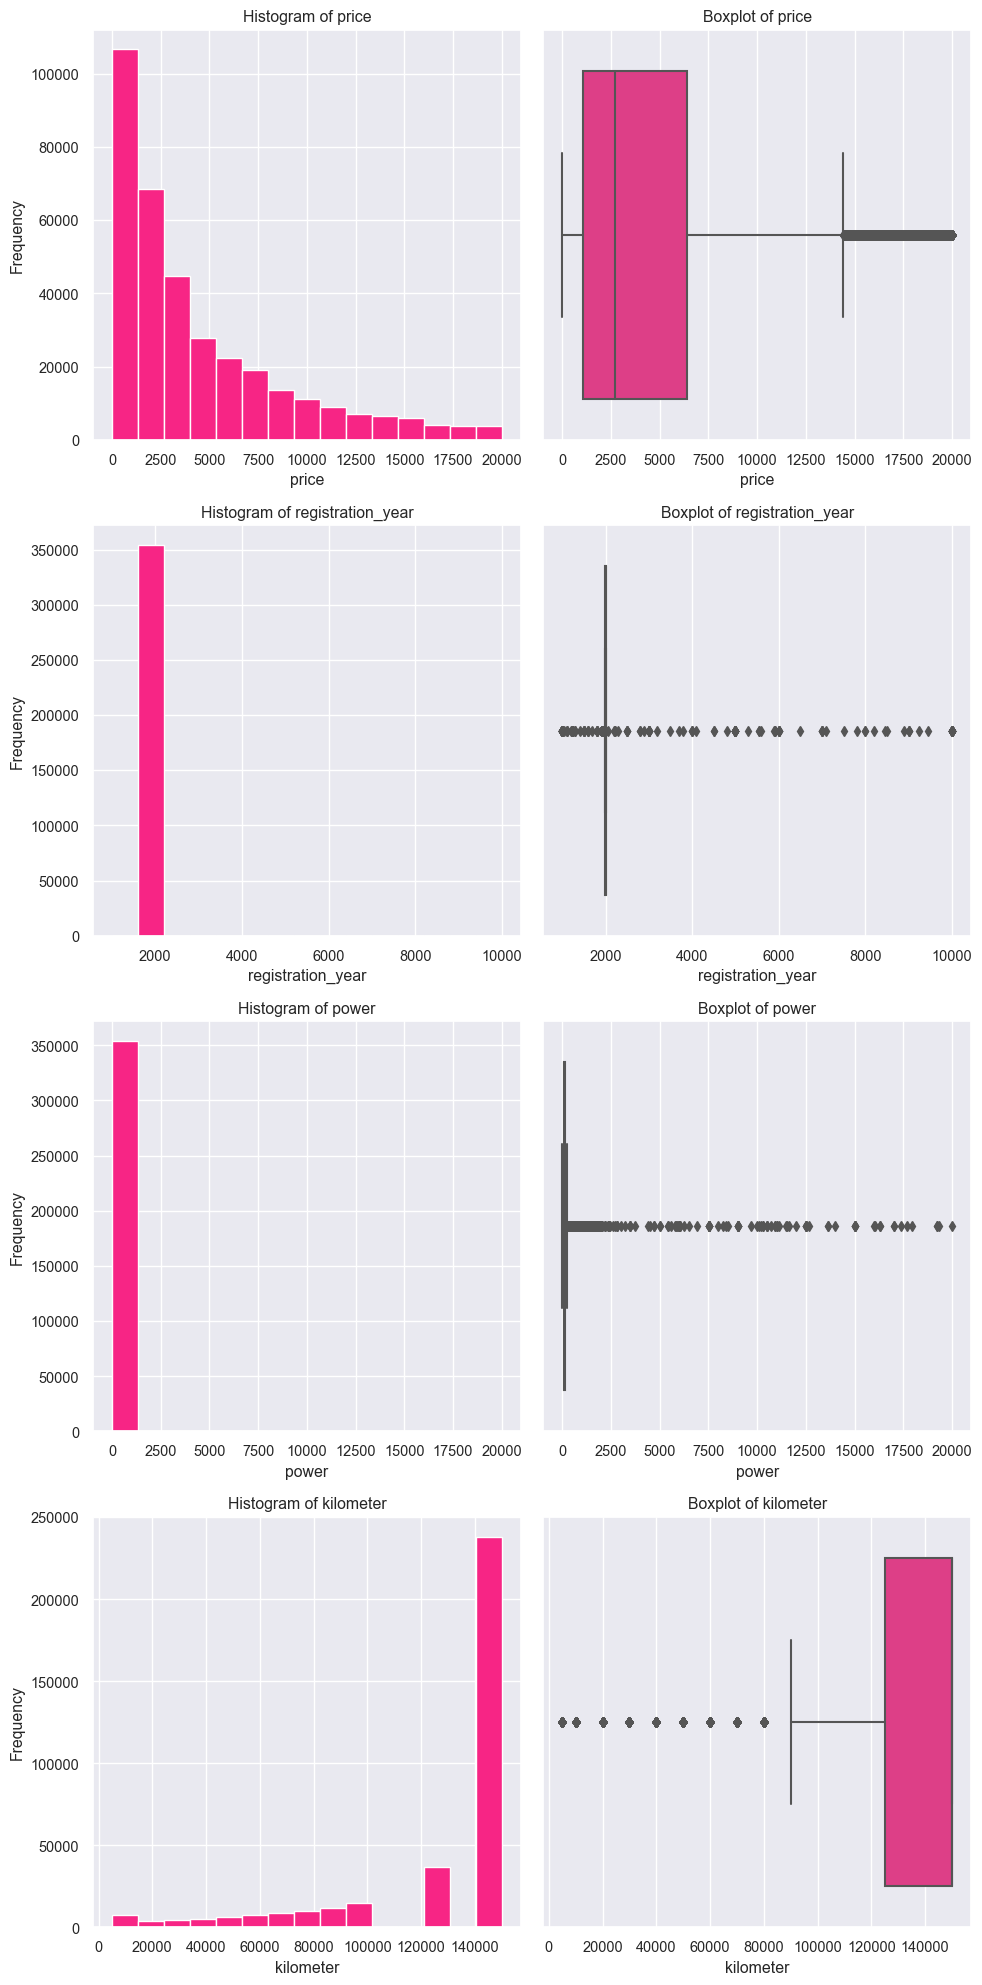

,count,mean,std,min,25%,50%,75%,max
price,354365.0,4416.68,4514.18,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354365.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
power,354365.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
kilometer,354365.0,128211.36,37905.08,5000.0,125000.0,150000.0,150000.0,150000.0


In [32]:
get_hist_box(main_autos)

**Вывод:** 
- `price` имеет распределение Пуассона. Дорогие машины (максимум - 20 000 евро) на боксплоте показаны как выбросы, но таковыми не являются, т.к. такая цена возможна. Минимальная стоимость 0 - это аномалия. Медиана - 2700.
- `registration_year`- присутствуют аномальные значения (1000 и 9999). Медиана - 2003.
- `power` - также встречаются аномальные значения (0 и 20 000). Медиана - 105.
- `kilometer` - максимальное и медиана равны 150 000 км, это нормальный пробег для авто, но непонятно почему нет значений больше. Пробег менее 80к км считается выбросом, т.к. это относительно небольшое значение (возрас авто примерно 3 года), но такие значения валидны. Минимальное значение - 5 000 км.

Проверим аномальные значения.

In [33]:
len(main_autos[main_autos['price'] == 0]) / len(main_autos)

0.030398035923412302

Доля автомобилей с ценой 0 составляет 3% от всех данных. Избавимся от аномалий.

In [34]:
main_autos = main_autos.query('price > 0')

len(main_autos[main_autos['price'] == 0])

0

Избавимся от выбросов раньше 1960 и позже 2016 года.

In [35]:
len(main_autos[main_autos['registration_year'] > 2016])\
/ len(main_autos)

0.040102679623857294

In [36]:
len(main_autos[main_autos['registration_year'] < 1960])\
/ len(main_autos)

0.000989542860302742

In [37]:
main_autos = main_autos.query(
    'registration_year >= 1960 and registration_year <= 2016')

len(main_autos[main_autos['registration_year'] < 1960]),\
len(main_autos[main_autos['registration_year'] > 2016])

(0, 0)

Проверим какую долю от данных составляют выбросы более 750 лошадиных сил или 0 л.с..

In [38]:
len(main_autos[main_autos['power'] > 750]) / len(main_autos)

0.0008862611313791073

In [39]:
len(main_autos[main_autos['power'] == 0]) / len(main_autos)

0.09934319551770397

Значения больше 750 удалим, а значения равные нулю заменим медианой.

In [40]:
main_autos = main_autos.query('power < 751')

pow_median = main_autos['power'].median()
main_autos['power'] = main_autos['power'].replace(0, pow_median)

len(main_autos[main_autos['power'] == 0]),\
len(main_autos[main_autos['power'] > 750])

(0, 0)

Еще раз построим графики.

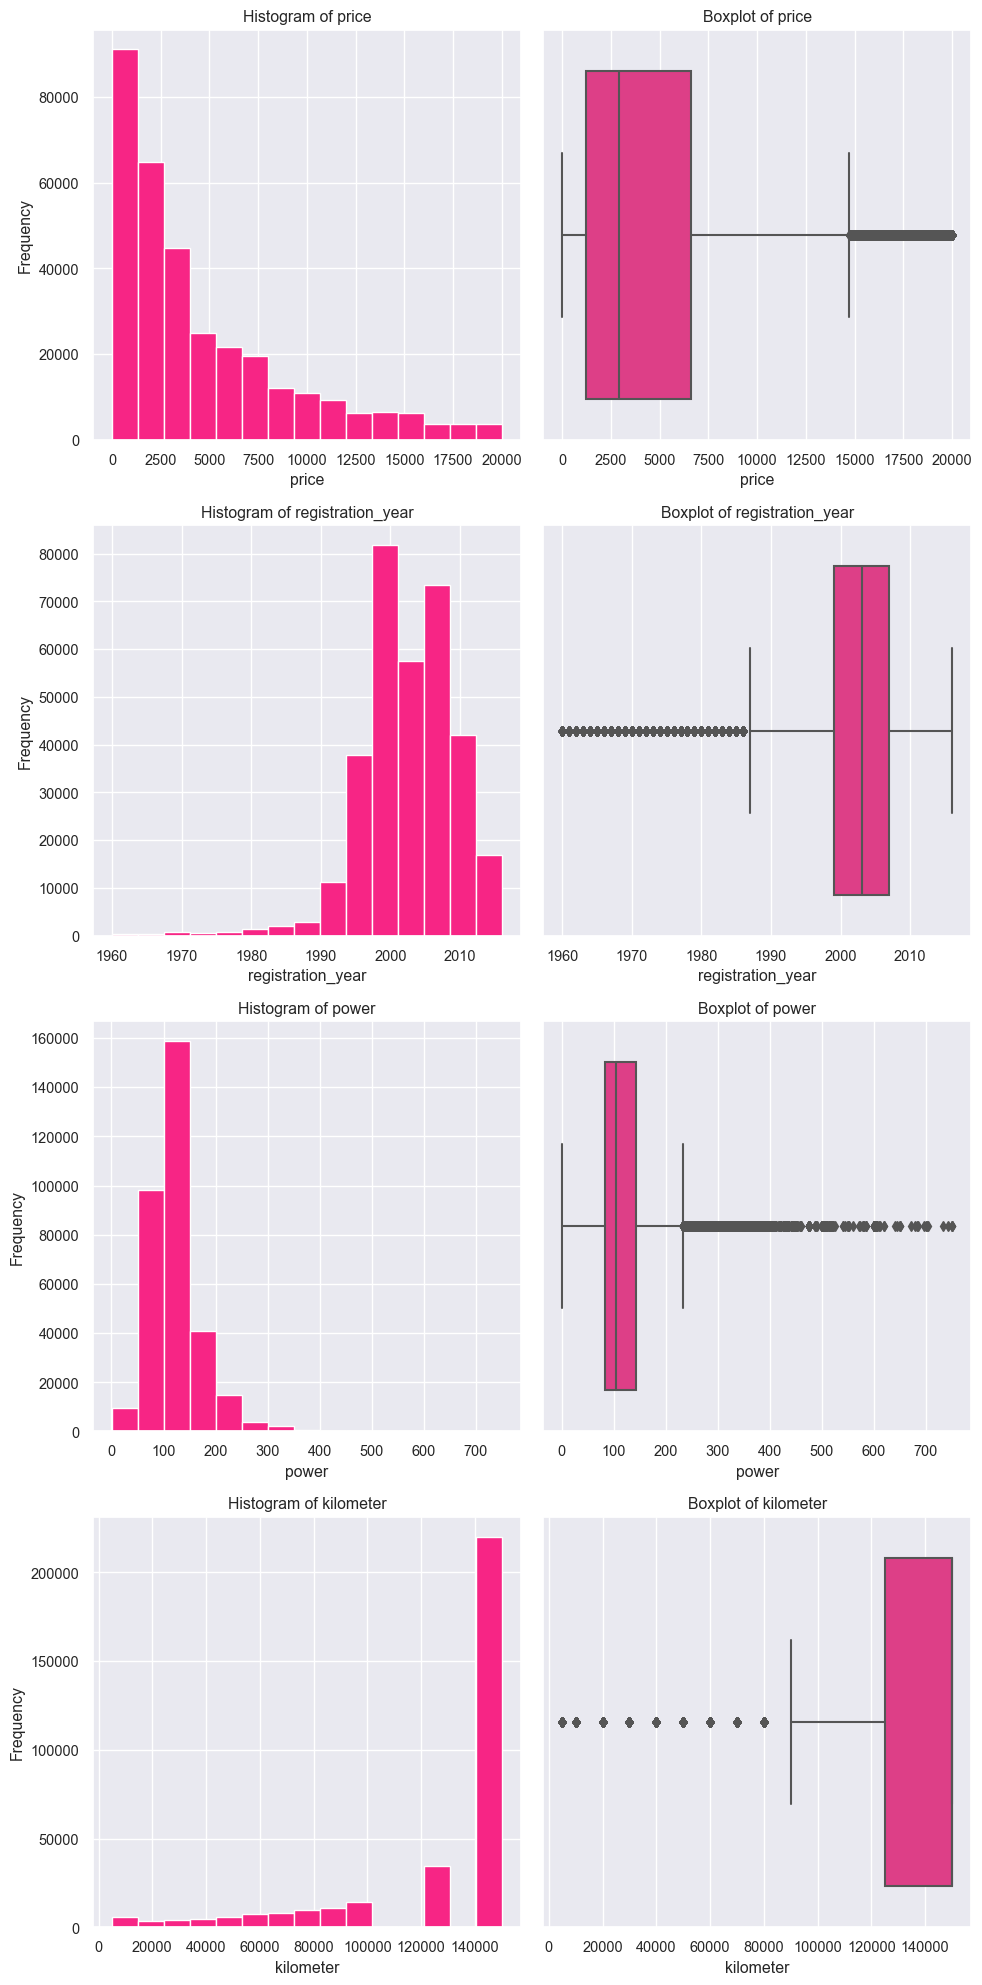

,count,mean,std,min,25%,50%,75%,max
price,329182.0,4606.05,4544.58,1.0,1200.0,2900.0,6600.0,20000.0
registration_year,329182.0,2002.65,6.67,1960.0,1999.0,2003.0,2007.0,2016.0
power,329182.0,119.11,51.65,1.0,83.0,105.0,143.0,750.0
kilometer,329182.0,128263.12,37451.66,5000.0,125000.0,150000.0,150000.0,150000.0


In [41]:
get_hist_box(main_autos)

Аномалии обработаны.

<a id='cat'></a>
### Категориальные признаки

In [42]:
# функция построения графиков для
# категориальных признаков
def get_catplot(df):
    colmns = df.drop('model', axis=1)
    colmns = colmns.select_dtypes(exclude=['number']).columns
    
    # размер графика
    plots = len(colmns)
    plt.figure(figsize=(10, 5 * plots))

    # построениеграфика для каждого столбца
    for i, col in enumerate(colmns):
        plt.subplot(plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(col)
        plt.ylabel(col)
        plt.xlabel('Frequency')
        
        print(round(autos[col].value_counts(normalize=True), 2), '\n\n')

    plt.tight_layout()
    plt.show()

sedan          0.31
small          0.25
wagon          0.20
bus            0.09
convertible    0.06
coupe          0.05
suv            0.04
other          0.01
Name: vehicle_type, dtype: float64 


manual    0.81
auto      0.19
Name: gearbox, dtype: float64 


gasoline    0.98
lpg         0.01
cng         0.00
hybrid      0.00
other       0.00
electric    0.00
Name: fuel_type, dtype: float64 


volkswagen        0.22
opel              0.11
bmw               0.10
mercedes_benz     0.09
audi              0.08
ford              0.07
renault           0.05
peugeot           0.03
fiat              0.03
seat              0.02
mazda             0.02
skoda             0.02
smart             0.01
citroen           0.01
nissan            0.01
toyota            0.01
hyundai           0.01
sonstige_autos    0.01
volvo             0.01
mini              0.01
mitsubishi        0.01
honda             0.01
kia               0.01
suzuki            0.01
alfa_romeo        0.01
chevrolet         0.00
chry

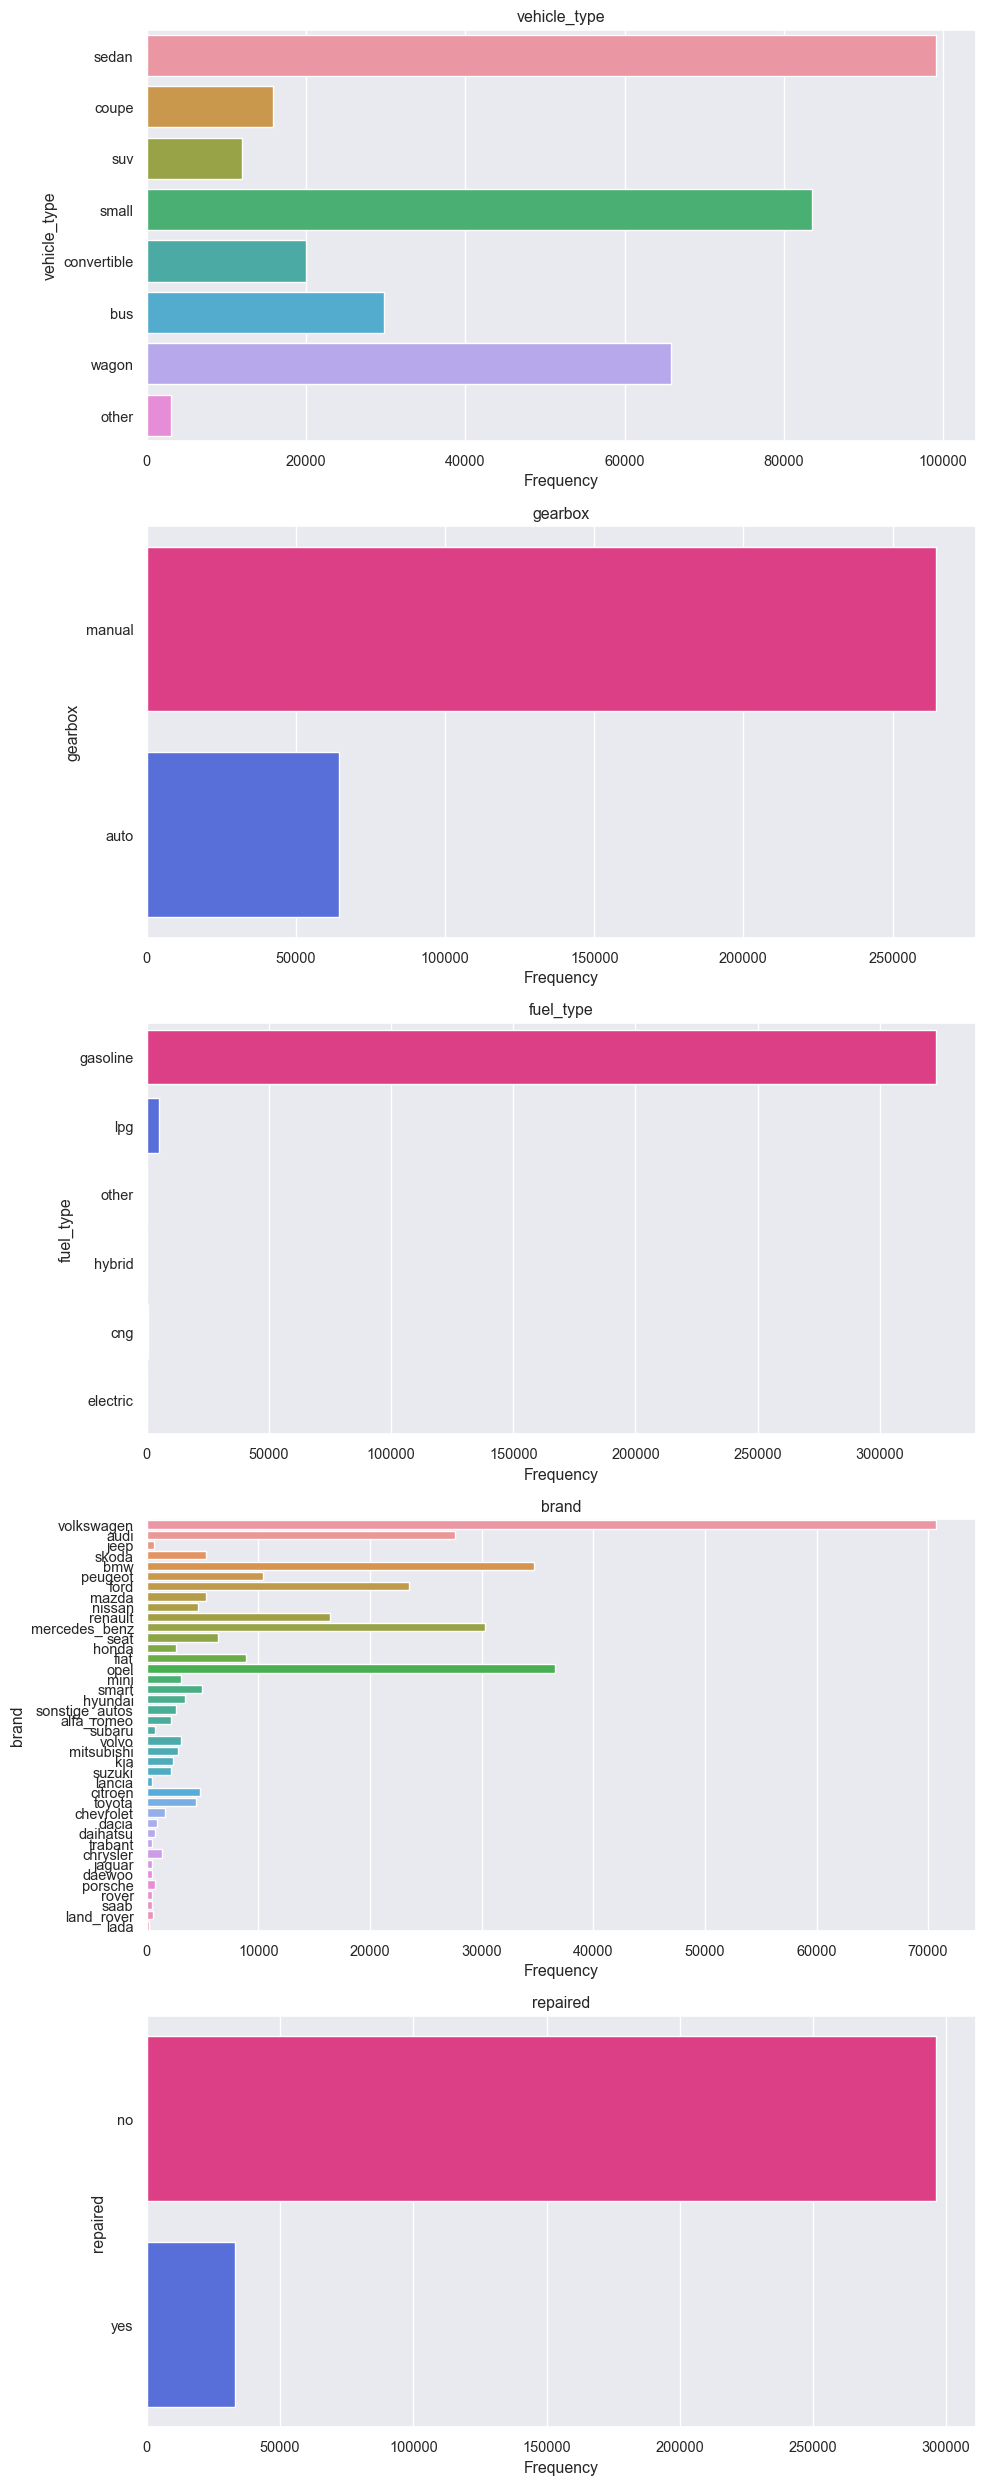

In [43]:
get_catplot(main_autos)

**Вывод:**
- Самые частые типы автомобильного кузова - это `sedan` (31%), `small` (25%), `wagon` (20%);
- Доли по типу коробки передач `manual` - 81%, `auto` - 19%;
- Наиболее частые типы топлива - `gasoline` (98%) и `lpg` (1%);
- Самые популярные бренды авто - `volkswagen` (22%), `opel` (11%) и `bmw` (10%);
- Большинство авто **не были в ремонте** (90%).

<a id='corr'></a>
### Корреляция

In [44]:
# функция матрицы корреляции
def phik_corr(df):
    phik_x = df.drop('price', axis=1)
    phik_y = df['price']
    interval_cols = df.select_dtypes(include=['number'])\
    .columns
    
    # считаем корреляции на тренировочной выборке
    phik_overview = phik_matrix(phik_x.join(phik_y), 
                            interval_cols=interval_cols) 
    
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, 
        color_map='Greens',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(10, 10)
    )

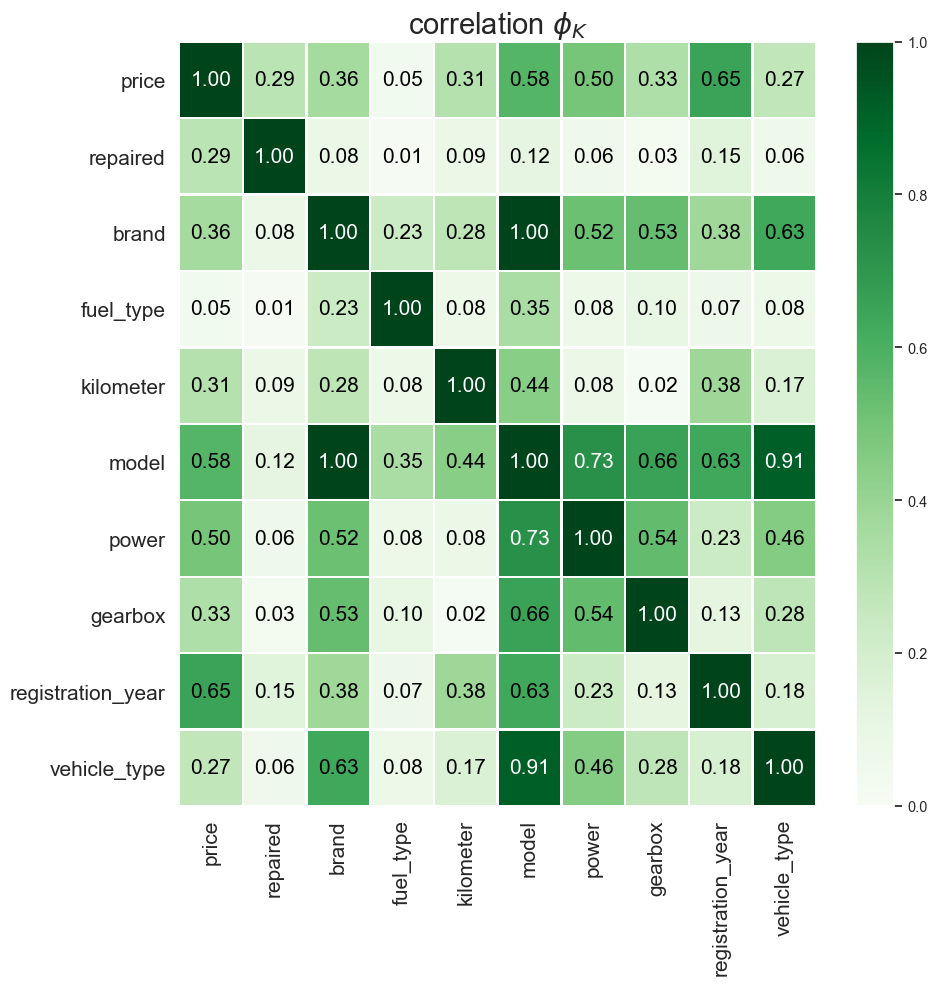

In [45]:
phik_corr(main_autos)

**Вывод:** 

- Между признаками `model` и `brand` наблюдается мультиколлинеарность (коэффициент 1). Необходимо удалить признак `brand` до обучения моделей.
- Между признаками `model` и `vehicle_type` также наблюдается сильная корреляция (коэффициент 0.91). 
- С целевым признаком `price` больше всего коррелируют `model`, `registration_year`, `power`; меньше всего - `fuel_type`.

**Общий вывод исследовательского анализа данных:**
- Найдены и обработаны аномалии.

Самые частые значения признаков: 

- `price`- 2900;
- `registration_year`- 2003;
- `power` - 105;
- `kilometer` - 150 000 км;
- `vehicle_type` - `sedan` (31%), `small` (25%), `wagon` (20%);
- `gearbox` - `manual` (81%);
- `fuel_type` - `gasoline` (98%) и `lpg` (1%);
- `brand` - `volkswagen` (22%), `opel` (11%) и `bmw` (10%);
- Большинство авто **не были в ремонте** (90%).

Признак `brand` и `vehicle_type` следует удалить перед обучением моделей, так как они и признак `model` имеют мультиколлинеарность (коэффициент 1 и 0.91).
- С целевым признаком `price` больше всего коррелируют `model`, `registration_year`, `power`; меньше всего - `fuel_type`.

<a id='model'></a>
## Обучение моделей

<a id='prep'></a>
### Подготовка данных

Удаляем признаки `brand` и `vehicle_type`.

In [46]:
main_autos = main_autos.drop([
    'vehicle_type',
     'brand'],
    axis=1)
main_autos.head()

,price,registration_year,gearbox,power,model,kilometer,fuel_type,repaired
0,480,1993,manual,105.0,golf,150000,gasoline,no
1,18300,2011,manual,190.0,a4,125000,gasoline,yes
2,9800,2004,auto,163.0,grand,125000,gasoline,no
3,1500,2001,manual,75.0,golf,150000,gasoline,no
4,3600,2008,manual,69.0,fabia,90000,gasoline,no


Проверим наличие дубликатов и удалим их.

In [47]:
main_autos.duplicated().sum()

68376

In [48]:
main_autos = main_autos.drop_duplicates().reset_index(drop=True)
main_autos.shape

(260806, 8)

Разделим данные на выборки.

In [49]:
X = main_autos.drop('price', axis=1)
y = main_autos['price']

num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.select_dtypes(exclude='number').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = TEST_SIZE,
        random_state = RANDOM_STATE
    )
num_col, cat_col

(['registration_year', 'power', 'kilometer'],
 ['gearbox', 'model', 'fuel_type', 'repaired'])

Создаем списки с названиями признаков для дальнейшей обработки.

In [50]:
# признаки для OneHotEncoder
ohe_col = ['fuel_type']
# признаки для OrdinalEncoder
ord_col = ['model', 'gearbox', 'repaired']
# для масштабирования - num_col уже есть

In [51]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [(
       'simpleImputer_ohe', 
       SimpleImputer(
           missing_values=np.nan, 
           strategy='most_frequent')), 
        
       ('ohe', 
     OneHotEncoder(
         drop='first', 
         handle_unknown='error', 
         sparse=False)
    )]
)

# SimpleImputer + ORD
ord_pipe = Pipeline(
    [(
        'simpleImputer_before_ord', 
        SimpleImputer(
            missing_values=np.nan, 
            strategy='most_frequent')),   
        
    ('ord',  
     OrdinalEncoder( 
         handle_unknown='use_encoded_value', 
         unknown_value=np.nan )),
        
    ('simpleImputer_after_ord', 
     SimpleImputer(
         missing_values=np.nan, 
         strategy='most_frequent'))
   ]
)

In [52]:
preprocessor = ColumnTransformer(
   [('ohe', ohe_pipe, ohe_col),
    ('ord', ord_pipe, ord_col),
    ('num', MinMaxScaler(), num_col)
   ],
   remainder='passthrough'
)

In [53]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', LinearRegression())
])

<a id='lin'></a>
### Линейная модель

In [54]:
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],  
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              'passthrough']  
    }
]

rs_lr = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

rs_lr.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', rs_lr.best_estimator_)
print ('RMSE:', rs_lr.best_score_)

Модель и лучшие параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['fuel_type']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                             

In [55]:
# для дальнейшего сравнения моделей
models = []
models.append(rs_lr)

<a id='lgbm'></a>
### Модель LightGBM

In [56]:
# переведем категориальные признаки в тип category
# который требуется для LightGBM
X_train_lgb = X_train
X_test_lgb = X_test
X_train_lgb[cat_col] = X_train[cat_col].astype('category')
X_test_lgb[cat_col] = X_test[cat_col].astype('category')

X_train_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195604 entries, 108276 to 220149
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   registration_year  195604 non-null  int64   
 1   gearbox            195604 non-null  category
 2   power              195604 non-null  float64 
 3   model              195604 non-null  category
 4   kilometer          195604 non-null  int64   
 5   fuel_type          195604 non-null  category
 6   repaired           195604 non-null  category
dtypes: category(4), float64(1), int64(2)
memory usage: 6.9 MB


In [57]:
model_lgbm = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

param_grid_lgbm = {
    'num_leaves': [50, 100, 200],
    'max_depth': [10, 50, 100]
}

rs_lgbm = RandomizedSearchCV(
    estimator=model_lgbm, 
    param_distributions=param_grid_lgbm, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=5
)

rs_lgbm.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', rs_lgbm.best_estimator_)
print ('RMSE:', rs_lgbm.best_score_)

Модель и лучшие параметры:

 LGBMRegressor(max_depth=50, num_leaves=200, objective='root_mean_squared_error',
              random_state=52, verbose=-1)
RMSE: -1788.9898388619579


In [58]:
models.append(rs_lgbm)

<a id='tree'></a>
### Модель DecisionTreeRegressor

In [59]:
param_grid_tree = [
   # словарь для модели DecisionTreeRegressor()
   {
       'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
       'models__min_samples_split': range(2, 300),
       'models__min_samples_leaf': range(2, 100),
       'models__max_depth': range(2, 200),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },
]


rs_tree = RandomizedSearchCV(
    pipe_final,
    param_grid_tree,
    cv = 5,
    n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

rs_tree.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', rs_tree.best_estimator_)
print ('RMSE:', rs_tree.best_score_)

Модель и лучшие параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['fuel_type']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                             

In [60]:
models.append(rs_tree)

<a id='comp'></a>
### Сравнение моделей

In [61]:
RMSE = []
time_lnrn_list = []
time_pred_list = []

for mod in models:
    RMSE.append(-mod.best_score_)
    model = mod.best_estimator_
    
    start_lnrn = time()
    model.fit(X_train, y_train)
    end_lnrn = time()
    time_lnrn = (end_lnrn - start_lnrn) / 60
    time_lnrn_list.append(time_lnrn)
    
    start_pr = time()
    model.predict(X_train)
    end_pr = time()
    time_pred = (end_pr - start_pr) / 60
    time_pred_list.append(time_pred)   

In [62]:
models_df = pd.DataFrame(
    {'model':['LinearRegression', 'LightGBM', 'DecisionTree'],
     'RMSE': RMSE,
     'learning_time': time_lnrn_list,
     'predict_time': time_pred_list,
     
    }
)
models_df

,model,RMSE,learning_time,predict_time
0,LinearRegression,3297.610469,0.005502,0.002776
1,LightGBM,1788.989839,0.011868,0.009458
2,DecisionTree,2056.466950,0.011453,0.003374


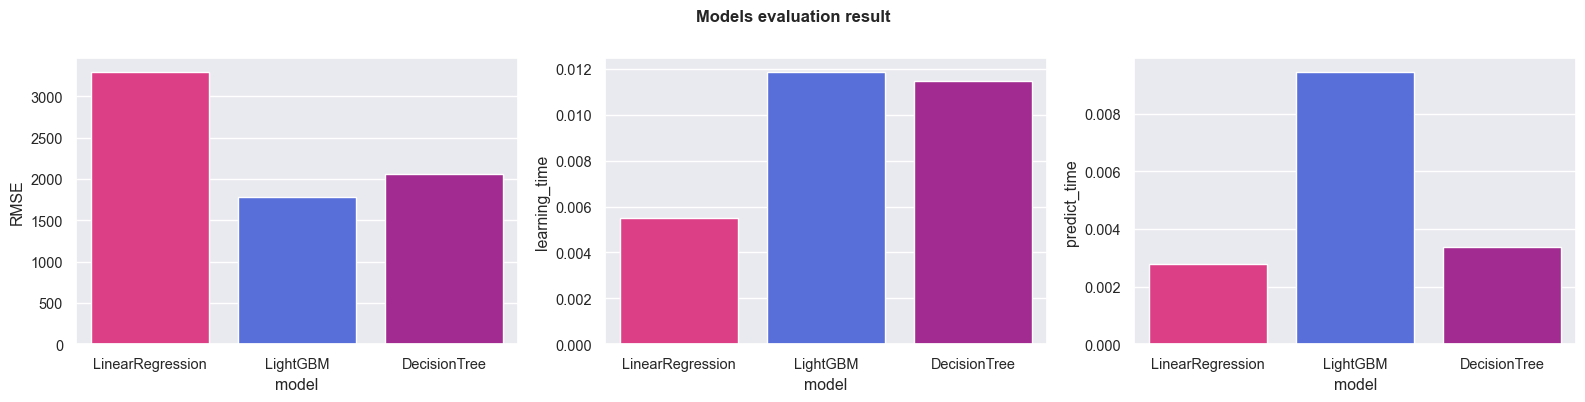

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle('Models evaluation result',
                 x=0.5,
                 y=1.0,
                 fontsize=12,
                 fontweight='bold'
                )        
sns.barplot(data=models_df,
            x='model',
            y='RMSE',
            ax=axes[0]
           )
sns.barplot(data=models_df,
            x='model',
            y='learning_time',
            ax=axes[1]
           )
sns.barplot(data=models_df,
            x='model',
            y='predict_time',
            ax=axes[2]
           )

plt.tight_layout()
plt.show;

**Выводы:** 
- модель `LinearRegression` не подходит заказчику, так как значение метрики **RMSE** должно быть меньше 2500, а у линейной регрессии выходит намного больше (3297.610).
- `DecisionTree` учатся быстрее чем `LightGBM` на 0.0005 минуты, а вот предсказание делает значительно быстрее.
- значение метрики **RMSE** меньшее у модели `LightGBM`, но эта модель дольше остальных и обучается и делает предсказания.

Лучшей моделью является **DecisionTree** с параметрами `max_depth=152`, `min_samples_leaf=11`, `min_samples_split=4`. Модель дает следующие результаты:
- Метрика **RMSE:** 2056.467
- Время обучения: 0.011 минуты	
- Время предсказания: 0.003 минуты

<a id='test'></a>
### Качество лучшей модели на тестовой выборке

In [64]:
best_model = rs_tree.best_estimator_

start_test = time()
RMSE_test = mean_squared_error(
    y_test,
    best_model.predict(X_test), 
    squared = False)
end_test = time()
test_time = (end_test - start_test) / 60 

print('RMSE на тестовой выборке: ', RMSE_test)
print('Время предсказания на тестовой выборке: ', test_time)

RMSE на тестовой выборке:  2062.2013013958435
Время предсказания на тестовой выборке:  0.0014632344245910645


<a id='fin'></a>
## Общие выводы

**Цели проекта выполнены:** 
- Загружены, изучены и очищены данные.
- Подготовлены выборки для обучения моделей.
- Обучены разные модели и подобраны гиперпараметры.
- Проанализировано время обучения, время предсказания и качество моделей.
- Выбрана лучшая модель, предсказывающая рыночную стоимость автомобиля, проверено её качество на тестовой выборке.

**Исходные данные:**
- Данные об автомобилях, находящиеся в файле `autos.csv`.
- **Целевой признак:** `Price` — цена (евро)

**В ходе выполнения работы проделаны следующие шаги:**
- Загружены и проверены соответствия данных в датафреймах;
- В результате **предобработки данных** 
    - названия столбцов датафрейма приведены к змеиному регистру;
    - найдены и удалены явные дубликаты;
    - найдены и обработаны неявные дубликаты;
    - обработаны пропуски: данные приведены к моде по значению другого подходящего столбца (бренда или модели авто).
- В ходе **исследовательского анализа данных**:
    - удалены автомобили с нулевой стоимостью;
    - значение `power` равное `0` л.с. заменено на медиану, автомобили с мощьностью более 650 л.с. удалены из выборки;
    - удалены записи, где `registration_year` более `2016` и менее `1885`;
    - проведен корреляционный анализ.
        - найдена мультиколлинеарность между признаками `model` и `brand` и силльный коэффициент корреляции между признаками `model` и `vehicle_type`.
        - изучены коэффициенты корреляции, с целевым признаком `price` больше всего коррелируют `model`, `registration_year`, `power`; меньше всего - `fuel_type`.
    - удалены признаки `date_crawled `, `vehicle_type`, `registration_month`, `brand`, `date_created`, `number_of_pictures`, `postal_code`, `last_seen`.
--------------------------------------------------------------------------
Самые частые значения признаков выглядят следующим образом:
- `price` - 2900 евро;
- `registration_year`- 2003;
- `power` - 105;
- `kilometer` -  150 000 км;
- `vehicle_type` - sedan (31%), small (25%), wagon (20%);
- `gearbox` - manual (81%);
- `fuel_type` - gasoline (98%);
- `brand` - volkswagen (22%), opel (11%) и bmw (10%);
- `repaired` - большинство авто **не были в ремонте** (90%).

--------------------------------------------------------------------------
- Обучены модели (`LinearRegression`, `LightGBM`, `DecisionTree`): 
     - Лучшей моделью является **DecisionTree** с параметрами `max_depth=152`, `min_samples_leaf=11`, `min_samples_split=4`. Модель дает следующие результаты:
        - Метрика **RMSE** на тренировочной выбборке: 2056.467
        - Метрика **RMSE** на тестовой выбборке: 2062.201
        - Время обучения: 0.011 минуты	
        - Время предсказания на тренировочной: 0.003 минуты
        - Время предсказания на тестовой: 0.001 минуты

In [65]:
models_df

,model,RMSE,learning_time,predict_time
0,LinearRegression,3297.610469,0.005502,0.002776
1,LightGBM,1788.989839,0.011868,0.009458
2,DecisionTree,2056.466950,0.011453,0.003374


Рекомендуется использовать модель дерева решений (**DecisionTree**) с параметрами {`max_depth=152`, `min_samples_leaf=11`, `min_samples_split=4`}, так как она подходит под критерии заказчика (скорость и качество обучения и предсказаний).

- В дальшейшем можно улучшить качество предсказаний используя другие виды моделей машинного обучения и/или другой набор гиперпараметров. 
- Для улучшения качества предсказаний следует избавиться от неинформативных признаков (кол-во фотографий, почтовый индекс владельца анкеты и тд.), проследить и исключить аномалии в данных (год, мощность и тп.), а также добавить новые признаки, влияющие на стоимость автомобиля.

[Наверх][1]

[1]:#task